In [42]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os

from typing import Callable

# Study an integral
* <big> $ S = \displaystyle \int_a^b  \displaystyle \frac{1}{\sqrt{1 + x^2}} \, dx$ </big>, where $a = 5$ and $b = 7$
1. Compute analytically the value of $S$
2. Provide a parallel numerical computation of the integral $S$ using, for example, the trapezoidal approximation $\displaystyle \int_{a}^{b} f(x) \approx S_D = \displaystyle \sum_{k = 1}^{N-1} \displaystyle \frac{f\left(a + k \,\tau\right)+ f\left(a + \left(k - 1\right) \tau\right) }{2}\,\,\tau$, where $ a + (N - 1)\tau = b$
  * The number of MPI processes $n_p$ does not depend on the number of discretization points $N$, i.e., $n_p \ne N$ in general. 
  * Use <strong>Reduce </strong> function of <i>mpi4py </i> to sum across processes.
3. Plot the speedup $s(n_p)$ for a parallel version of program for different number of processes $n_p$. The speedup is determined by $s(n_p) = \displaystyle \frac{t_p(n_p)}{t_s}$, where $t_s$ and $t_p(n_p)$ are computational times of sequential and parallel versions of program.
4. Plot the error value $e(\tau) = |S_D(\tau) - S| $ versus discretization step graph $\tau$ by varying number of discretization steps $N$.

## Analytical result

By substitution $x = \sinh{t}$, we have

$\int f(x) = \int\frac{\cosh{t}dt}{\sqrt{1+\sinh^2{t}}} = \int \frac{\cosh{t}dt}{\cosh{t}} = \int 1 dt = \text{ arsinh}{x} + c = \ln\left(x + \sqrt{x^2 + 1}\right) +c$

In [2]:
def calc_true_integral_value(a: int, b: int) -> float:
    def func(x):
        return np.log(x + (x**2 + 1)**(1 / 2))
    
    return func(b) - func(a)

In [3]:
calc_true_integral_value(5, 7)

0.33168241978587654

## Approximation

In [4]:
def calc_inner_func(x: float) -> float:
    return 1 / (1 + x**2)**(1 / 2)

def calc_trapezoid(inner_func: Callable[[float], float], a: int, b: int, num_discr_points : int = 1) -> float:

    delta = (b - a) / num_discr_points
    
    # define approximation for zero and last iterations (points a and b)
    approximation = inner_func(a) + inner_func(b)
    
    for i in range(1, num_discr_points):
        approximation += 2 * inner_func(a + delta * i)
        
    return approximation * delta / 2

In [40]:
calc_trapezoid(calc_inner_func, 5, 7, 1000)

0.33168242575775947

The approximation and analytical values are close, this is a good sign :)

## Integration error vs number of points

In [6]:
points = np.arange(1, 100000, 1000)

In [7]:
diffs = []
for num_points in tqdm(points):
    diff = abs(calc_true_integral_value(5, 7) - calc_trapezoid(calc_inner_func, 5, 7, num_points))
    diffs.append(diff)          

100%|██████████| 100/100 [00:07<00:00,  6.92it/s]


For better visual representation we will plot errors in log scale

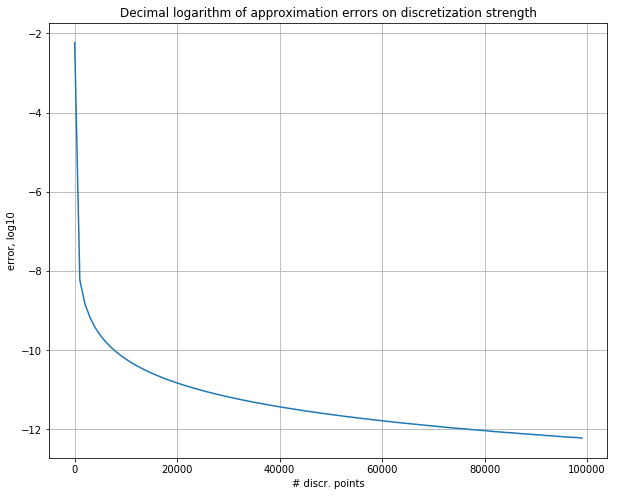

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(points, np.log10(diffs))
ax.grid()
ax.set_xlabel('# discr. points')
ax.set_ylabel('error, log10')
ax.set_title('Decimal logarithm of approximation errors on discretization strength')

fig.savefig('integral_error.png')

## Show speedup

In [47]:
if os.path.exists('times'):
    os.remove('times')
for i in tqdm(range(1, 13)):
    os.system(f'mpirun -n {i} python mpi_integral.py --return_time -n_discr_points=10000000')

100%|██████████| 12/12 [00:54<00:00,  5.88s/it]


In [48]:
proc_times = {}

with open('times', 'r') as f:
    for line in f.readlines():
        proc, times = line.strip().split()
        proc_times[int(proc)] = float(times)

initial_time = proc_times[1]
proc_times

{1: 3.46,
 2: 1.7211,
 3: 1.2351,
 4: 0.9371,
 5: 1.5471,
 6: 2.0229,
 7: 1.7239,
 8: 1.6362,
 9: 1.7475,
 10: 1.9025,
 11: 1.9816,
 12: 1.7708}

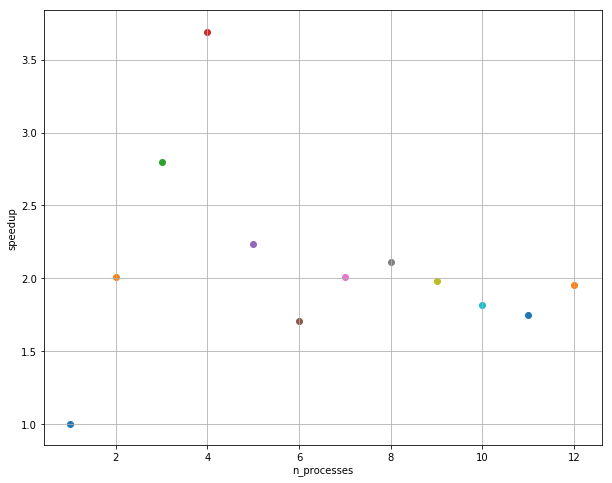

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for n_proc, time in proc_times.items():
    ax.scatter(n_proc, initial_time / time)

ax.grid()
ax.set_xlabel('n_processes')
ax.set_ylabel('speedup')

fig.savefig('speedup.png')